In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-01 13:01:04.765776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 13:01:04.765793: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [1]:
from ML_classes.LinearModel import LinearModel


2022-03-10 11:28:09.071768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 11:28:09.071784: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = LinearModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.LinearModel()

Epoch 1/10
 1/66 [..............................] - ETA: 8s - loss: 0.0245

2022-03-01 13:01:08.171419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 13:01:08.171869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 13:01:08.171922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-01 13:01:08.171965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-01 13:01:08.172006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0257
Epoch 2/10
66/66 [==============================] - 0s 847us/step - loss: 0.0177 - val_loss: 0.0194
Epoch 3/10
66/66 [==============================] - 0s 648us/step - loss: 0.0140 - val_loss: 0.0151
Epoch 4/10
66/66 [==============================] - 0s 660us/step - loss: 0.0115 - val_loss: 0.0122
Epoch 5/10
66/66 [==============================] - 0s 686us/step - loss: 0.0097 - val_loss: 0.0102
Epoch 6/10
66/66 [==============================] - 0s 723us/step - loss: 0.0084 - val_loss: 0.0087
Epoch 7/10
66/66 [==============================] - 0s 777us/step - loss: 0.0075 - val_loss: 0.0077
Epoch 8/10
66/66 [==============================] - 0s 712us/step - loss: 0.0068 - val_loss: 0.0069
Epoch 9/10
66/66 [==============================] - 0s 618us/step - loss: 0.0063 - val_loss: 0.0064
Epoch 10/10
66/66 [==============================] - 0s 616us/step - loss: 0.0059 - val_loss: 0.0060


In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

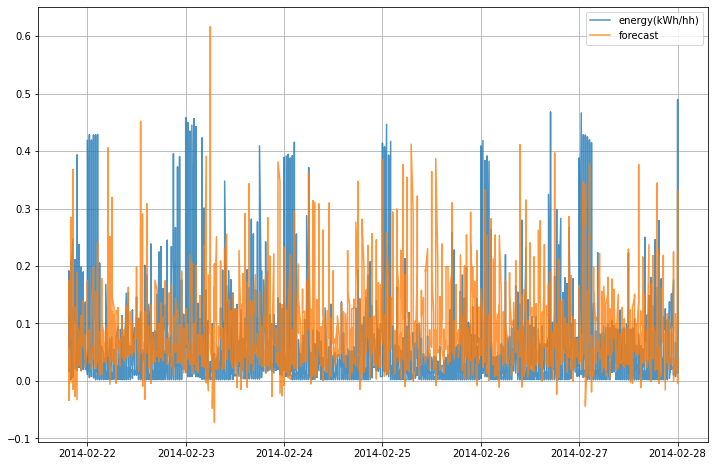

In [9]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_53559/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


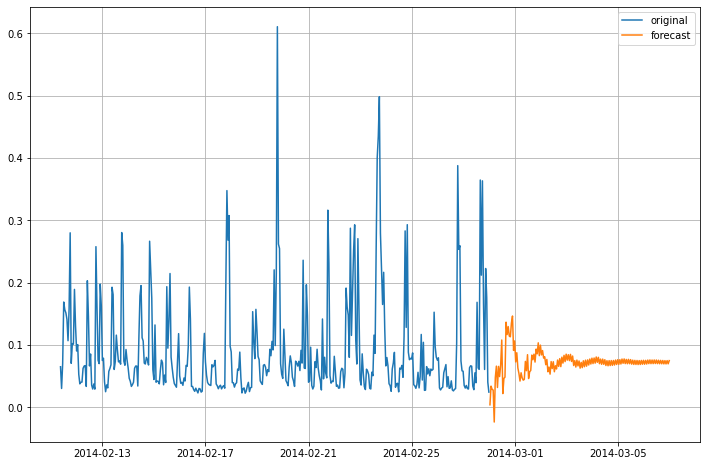

In [10]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [11]:
deep_learner.evaluateMSE()

0.006007080074772803

In [12]:
deep_learner.evaluateRMSE()

0.07750535513609884

In [13]:
deep_learner.evaluateMAE()

0.04838350489487226

In [14]:
deep_learner.evaluateMAPE()

56.628217020198385

In [15]:
yhat =deep_learner.predict()

In [16]:
yhat

[0.1174044,
 0.17386882,
 -0.019540831,
 0.07978978,
 -0.033611804,
 0.055877656,
 -0.002029337,
 0.012161367,
 0.09664014,
 0.28438377,
 0.084987134,
 0.0015754923,
 0.124479815,
 0.16426328,
 0.049229905,
 0.0746169,
 0.06975202,
 0.30742037,
 0.36762965,
 0.33759052,
 0.14661571,
 0.24623868,
 0.24474937,
 0.15900417,
 -0.014104925,
 0.11881691,
 0.04748866,
 0.012193829,
 -0.026921362,
 0.010957964,
 0.042214796,
 0.103274666,
 0.085172266,
 0.048545845,
 0.105260335,
 0.12862374,
 -0.032516252,
 0.06097579,
 0.14759696,
 0.18892731,
 0.10258378,
 0.16628698,
 0.102948286,
 0.08196241,
 0.07931334,
 0.09471112,
 0.086580075,
 0.047937177,
 0.05888222,
 0.041897036,
 0.049832862,
 0.057247967,
 0.047781877,
 0.02675763,
 0.07930091,
 0.07399532,
 0.042894308,
 0.01773509,
 0.039913274,
 0.07736367,
 0.11375025,
 0.08656004,
 0.09214558,
 0.055599898,
 0.08391833,
 0.057710633,
 0.06572296,
 0.11605202,
 0.07264693,
 0.0895932,
 0.1400243,
 0.08986218,
 0.08124645,
 0.07067458,
 0.06